Workflow for parallization:
- To create a story
- Parallely generate
    - premise
    - character
    - setting
- Finally merge them into one story
- end

In [1]:
from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END

from typing import Annotated, TypedDict, Literal
from dotenv import load_dotenv

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [3]:
class PrallelState(TypedDict):
    topic: str
    premise: str
    characters: str
    setting: str
    story_intro: str

In [6]:
def characters_node(state: PrallelState) -> PrallelState:

    characters = model.invoke(f"Generate two characters for a {state['topic']} story").content
    return {"characters": characters}

def premise_node(state: PrallelState) -> PrallelState:

    premise = model.invoke(f"Generate a one-sentence plot premise for a {state['topic']} story").content
    return {"premise": premise}

def setting_node(state: PrallelState) -> PrallelState:

    setting = model.invoke(f"Generate a vivid setting for a {state['topic']} story").content
    return {"setting": setting}

def story_node(state: PrallelState) -> PrallelState:
    prompt = f"""
    Generate a shortstory based on the following information:\n\n
    Topic: {state['topic']}
    Premise: {state['premise']}
    Characters: {state['characters']}
    Setting: {state['setting']}
    """
    story = model.invoke(prompt).content
    return {"story": story}

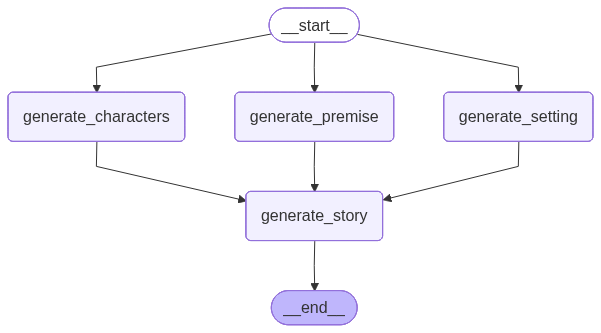

In [7]:
# Create a state graph
state_graph = StateGraph(PrallelState)

# Add start and end states

state_graph.add_node("generate_characters", characters_node)
state_graph.add_node("generate_premise", premise_node)
state_graph.add_node("generate_setting", setting_node)
state_graph.add_node("generate_story", story_node)

# Add edges
state_graph.add_edge(START, "generate_characters")
state_graph.add_edge(START, "generate_premise")
state_graph.add_edge(START, "generate_setting")
state_graph.add_edge("generate_characters", "generate_story")
state_graph.add_edge("generate_premise", "generate_story")
state_graph.add_edge("generate_setting", "generate_story")
state_graph.add_edge("generate_story", END)

# compile the graph
workflow = state_graph.compile()
workflow

In [8]:
initial_state = {"topic": "Time Travel"}

final_state = workflow.invoke(initial_state)
final_state

{'topic': 'Time Travel',
 'premise': 'When a brilliant but reclusive physicist discovers a way to communicate with her past self, she must navigate a complex web of cause and effect to prevent a catastrophic event that will erase her from existence.',
 'characters': "Here are two potential characters for a time travel story:\n\n**Character 1:**\n\n**Name:** Emily Wynton\n\n**Age:** 28\n\n**Occupation:** Historian and Professor of Archaeology\n\n**Appearance:** Emily is a petite woman with curly brown hair and bright green eyes. She has a small tattoo of the ancient symbol for the constellation Orion on her left ankle.\n\n**Personality:** Emily is a driven and intelligent individual with a passion for history. She is fiercely independent and can come across as aloof or standoffish to those who don't know her. However, she has a deep empathy for those who have come before her and is fiercely loyal to her friends and colleagues.\n\n**Background:** Emily grew up in a family of archaeologis